This notebook showcases the special projection DPP associated to the Uniform measure on Spanning Trees (UST) of a graph.

UST can be sampled with specific random walk based procedures such as Aldous-Broder-Broder and Wilson algorithms.

In [1]:
%pylab inline

%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, os.path.abspath('../dppy'))

from exotic_dpps import *

Populating the interactive namespace from numpy and matplotlib


/Users/ggautier/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/ggautier/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Uniform Spanning Trees

In [2]:
from itertools import combinations
from collections import Counter

## Initial graph

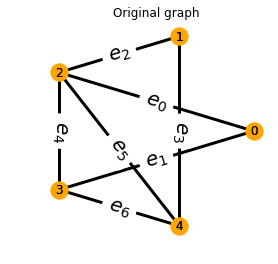

In [3]:
# Build graph
g = nx.Graph()
edges = [(0,2), (0,3), (1,2), (1,4), (2,3), (2,4), (3,4)]
g.add_edges_from(edges)

# Display the graph
ust = UST(g)
ust.plot_graph()

### Uniform Spanning Tree object
parametrized by a `networkx` graph (undirected and connected).

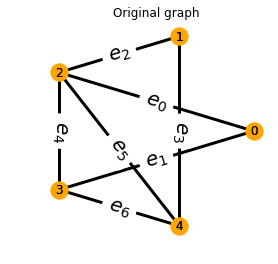

In [4]:
g = nx.Graph()
edges = [(0,2), (0,3), (1,2), (1,4), (2,3), (2,4), (3,4)]
g.add_edges_from(edges)

ust = UST(g)

ust.plot_graph()

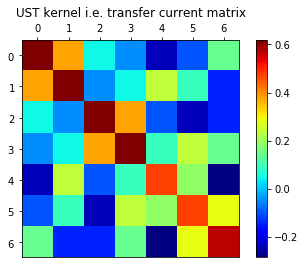

In [5]:
ust.compute_kernel()
ust.plot_kernel()

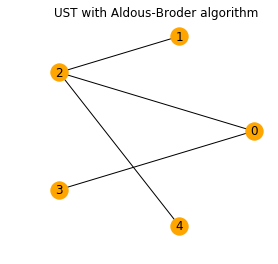

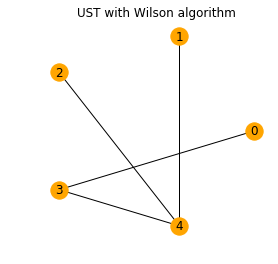

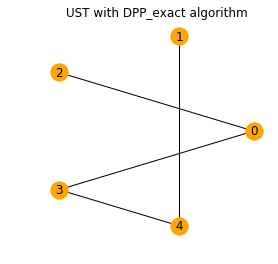

In [6]:
for md in ("Aldous-Broder", "Wilson", "DPP_exact"):
    ust.sample(md); ust.plot()

## Check uniformity of samples from each procedure

##### Compute the list of spanning trees of the graph

In [7]:
potential_st = combinations(np.arange(ust.nb_edges), ust.nb_nodes-1) # Spanning trees have |V|-1 edges
potential_st = np.array(list(potential_st))

ust.compute_kernel()
# minors of transfer current matrix of size |V|-1, if non zeros then corresponding edges form a spanning tree
is_st = lambda x: la.det(ust.kernel[np.ix_(x, x)])>1e-8 
list_st_by_edge_label = potential_st[list(map(is_st, potential_st))]

nb_st = len(list_st_by_edge_label)
print("There are {} spanning trees associated to this graph".format(nb_st))

There are 21 spanning trees associated to this graph


##### Sample from each sampling procedure and count the number of times each spanning tree has been sampled

In [8]:
nb_iter = 10000
modes = ("Aldous-Broder", "Wilson", "DPP_exact")

# For each algorithm (mode) count the number of occurence of each spanning tree
dict_sampled_st = {md:Counter(map(tuple, list_st_by_edge_label)) for md in modes}
dict_count_sampled_st = {md:np.zeros(nb_iter) for md in modes}

for md in modes:
    
    ust.flush_samples()
    for _ in range(nb_iter): ust.sample(md)

    sampled_st_edges = np.array([sampled_st.edges() for sampled_st in ust.list_of_samples])

    tmp = sampled_st_edges.reshape((nb_iter*(ust.nb_nodes-1), 2))
    tmp_labs = np.zeros(tmp.shape[0], dtype=int)

    for ind, ed in enumerate(ust.edges):
        tmp_labs[(tmp == ed).all(axis=1)] = ind

    tmp_labs = tmp_labs.reshape(nb_iter, (ust.nb_nodes-1))
    dict_sampled_st[md].update(map(tuple, tmp_labs))
    dict_count_sampled_st[md] = [dict_sampled_st[md][tuple(ed_lab)]-1 for ed_lab in list_st_by_edge_label]

##### Display the histogram

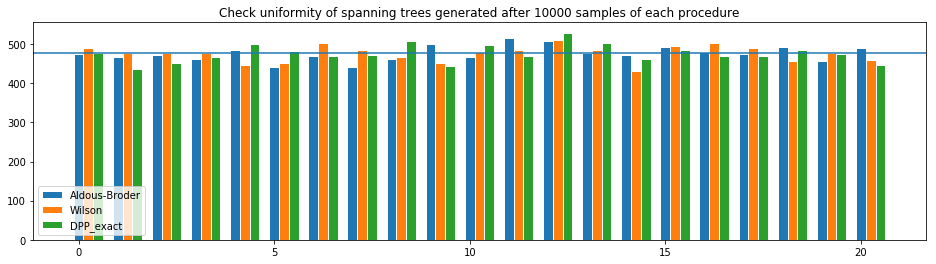

In [9]:
fig = plt.figure(figsize=(16,4))

# set width of bar
bar_width = 0.25

# Set position of bar on X axis
pos = np.arange(len(list_st_by_edge_label))
# Make the plot
for i, md in enumerate(modes):
    plt.bar(pos+i*bar_width, dict_count_sampled_st[md], width=bar_width, edgecolor='white', label=md)

plt.axhline(y=nb_iter/nb_st)
plt.legend(loc='best')
plt.title("Check uniformity of spanning trees generated after {} samples of each procedure".format(nb_iter))
#plt.show()

plt.savefig("ust_histo.png")
plt.savefig("ust_histo.eps")

# Carries Process

##### Choose base $b$ to sample i.i.d. digits in $\{0, \dots, b-1\}$

In [10]:
base = 10 # base
cp = CarriesProcess(base)

size = 100
cp.sample(size)

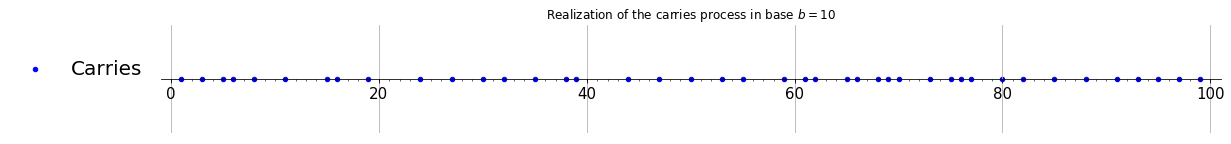

In [11]:
cp.plot()

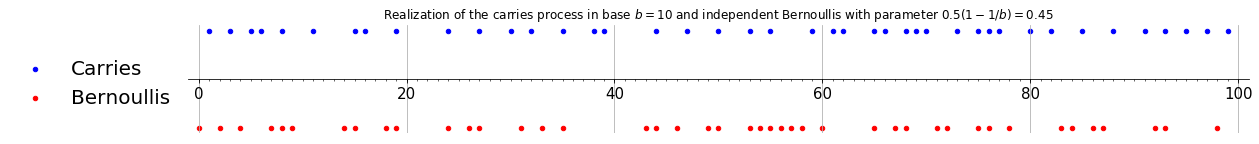

In [12]:
cp.plot_vs_bernoullis()

# Poissonized Plancherel measure

##### Choose a $\theta$ to sample a permutation $\sigma \in \mathfrak{S}_N$ with $N \sim \mathcal{P}(\theta)$

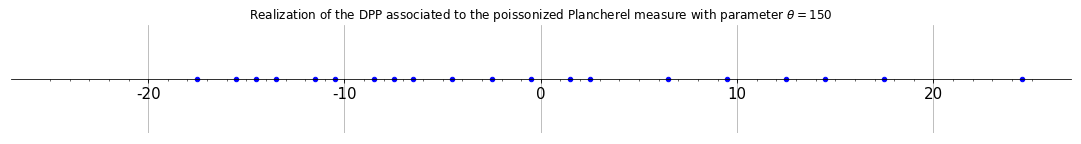

In [13]:
theta=150 # Poisson parameter
pp_dpp = PoissonizedPlancherel(theta=theta)
pp_dpp.sample()
pp_dpp.plot()